### ASSIGNMENT 2 - DATA ANALYSIS
Use the hotels-europe dataset and pick a city (other than Vienna). Each student/pair should
pick a different city with at least 250 hotels in the dataset after appropriate filtering of the
data. Sign up with the city chosen in this spreadsheet.
Once the city is chosen, first combine the prices dataset with the hotel features dataset. Then,
use hotel user ratings to create a binary variable: highly_rated=1 if rating ≥ 4, 0 otherwise.
Examine how high rating is related to the other hotel features in the data. Make sure to
document and argue for the data cleaning/filtering decisions you make.
Estimate linear probability, logit, and probit models with distance and stars as explanatory
variables. You may add other variables if you wish.
Compare coefficients, marginal differences, and predicted probabilities, and discuss your
results.


In [100]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff
from plotnine import *

from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf

from helper_funcs import *

from scipy.stats import logistic
from patsy import dmatrices
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss

## 1 - PREPARING THE DATA

In [101]:
hotel_feat = pd.read_csv("hotels-europe_features.csv")
hotel_prc = pd.read_csv("hotels-europe_price.csv")

In [102]:
hotel_feat.describe()

,hotel_id,distance,stars,rating,rating_reviewcount,ratingta,ratingta_count,distance_alter
count,22902.0,22902.0,17187.0,20722.0,20722.0,19909.0,19909.0,22902.0
mean,11451.5,2.8,3.3,3.9,136.9,3.9,435.5,4.5
std,6611.4,4.8,0.8,0.6,225.9,0.7,680.1,6.2
min,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
25%,5726.2,0.7,3.0,3.5,18.0,3.5,53.0,1.1
50%,11451.5,1.3,3.0,4.0,63.0,4.0,184.0,2.7
75%,17176.8,2.6,4.0,4.4,161.0,4.5,530.0,6.0
max,22902.0,57.0,5.0,5.0,4300.0,5.0,17139.0,65.0


In [103]:
# Checking that the feature database has no duplicates
hotel_feat.drop_duplicates(subset = ['hotel_id'], inplace = True)
# Dropping all NA values from the rating column
hotel_feat.dropna(subset = ['rating'], inplace = True)

In [104]:
hotel_prc.offer_cat.value_counts()

offer_cat
0% no offer      61626
15-50% offer     48822
1-15% offer      23838
50%-75% offer    10766
75%+ offer        2969
Name: count, dtype: int64

In [105]:
# Creating a price-per-night variable
hotel_prc["price_nite"] = hotel_prc["price"] / hotel_prc["nnights"]

#### Splitting the price databse in 4 separate datasets: standard price, low, medium and high promotion.
Promotions over 75% account for few values and will not be considered.

In [106]:
hotel_std = hotel_prc.loc[(hotel_prc["offer"] == 0)]
hotel_lo_off = hotel_prc.loc[(hotel_prc["offer"] == 1) & (hotel_prc["offer_cat"] == "1-15% offer")]
hotel_med_off = hotel_prc.loc[(hotel_prc["offer"] == 1) & (hotel_prc["offer_cat"] == "15-50% offer")]
hotel_hi_off = hotel_prc.loc[(hotel_prc["offer"] == 1) & (hotel_prc["offer_cat"] == "50%-75% offer")]

#### On the "no offer" dataset, grouping by hotel ID and avoiding duplicates by retaining only one value per hotel.

In [107]:
# Group by 'hotel_id' and take first cell for multiple entries except for price where we calculate the average 'price'
hotel_std = hotel_std.groupby('hotel_id', as_index = False).agg({'offer_cat': 'first','price_nite' : 'mean'}, inplace = True)

In [108]:
hotel_std

,hotel_id,offer_cat,price_nite
0,1,0% no offer,172.0
1,2,0% no offer,124.9
2,3,0% no offer,217.0
3,5,0% no offer,922.0
4,8,0% no offer,226.9
...,...,...,...
15040,22897,0% no offer,73.8
15041,22898,0% no offer,34.0
15042,22899,0% no offer,77.1
15043,22900,0% no offer,124.4


#### Dropping unnecessary columns on the "promo" datasets

In [110]:
columns_to_drop = [
    'price',
    'offer',
    'year',
    'month',
    'weekend',
    'holiday',
    'nnights',
    'scarce_room']
hotel_lo_off.drop(columns = columns_to_drop, inplace = True)
hotel_med_off.drop(columns = columns_to_drop, inplace = True)
hotel_hi_off.drop(columns = columns_to_drop, inplace = True)

In [111]:
# Renaming new DataFrames' columns
new_columns_low = {'price_nite': 'price_lo_off', 'offer_cat': 'offer_low'}
new_columns_med = {'price_nite': 'price_med_off', 'offer_cat': 'offer_med'}
new_columns_high = {'price_nite': 'price_hi_off', 'offer_cat': 'offer_high'}

hotel_lo_off.rename(columns = new_columns_low, inplace = True)
hotel_med_off.rename(columns = new_columns_med, inplace = True)
hotel_hi_off.rename(columns = new_columns_high, inplace = True)


#### Merging all "promo" dataframes into one dataset

In [112]:
hotelp = pd.merge(hotel_std, hotel_lo_off, on = "hotel_id", how = 'outer')
hotelp = pd.merge(hotelp, hotel_med_off, on = "hotel_id", how = 'outer')
hotelp = pd.merge(hotelp, hotel_hi_off, on = "hotel_id", how = 'outer')

In [113]:
hotelp

,hotel_id,offer_cat,price_nite,offer_low,price_lo_off,offer_med,price_med_off,offer_high,price_hi_off
0,1,0% no offer,172.0,1-15% offer,138.0,15-50% offer,122.0,NaN,NaN
1,1,0% no offer,172.0,1-15% offer,138.0,15-50% offer,122.0,NaN,NaN
2,1,0% no offer,172.0,1-15% offer,138.0,15-50% offer,122.0,NaN,NaN
3,1,0% no offer,172.0,1-15% offer,138.0,15-50% offer,114.0,NaN,NaN
4,2,0% no offer,124.9,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
105984,22855,NaN,NaN,NaN,NaN,NaN,NaN,50%-75% offer,31.0
105985,22855,NaN,NaN,NaN,NaN,NaN,NaN,50%-75% offer,35.0
105986,22855,NaN,NaN,NaN,NaN,NaN,NaN,50%-75% offer,30.0
105987,22855,NaN,NaN,NaN,NaN,NaN,NaN,50%-75% offer,36.0


#### Cleaning up columns

In [114]:
# Group by 'hotel_id' and take first or last cell for multiple entries except for price where we calculate the average 'price'
hotelp = hotelp.groupby('hotel_id', as_index = False).agg({
    'offer_cat':'first',
    'price_nite' : 'mean',
    'offer_low': 'first',
    'price_lo_off': 'mean',
    'offer_med': 'first',
    'price_med_off': 'mean',
    'offer_high': 'first',
    'price_hi_off': 'mean'
    })

In [115]:
hotelp

,hotel_id,offer_cat,price_nite,offer_low,price_lo_off,offer_med,price_med_off,offer_high,price_hi_off
0,1,0% no offer,172.0,1-15% offer,138.0,15-50% offer,120.0,None,NaN
1,2,0% no offer,124.9,None,NaN,None,NaN,None,NaN
2,3,0% no offer,217.0,1-15% offer,184.2,15-50% offer,116.3,None,NaN
3,4,None,NaN,None,NaN,15-50% offer,115.0,50%-75% offer,71.0
4,5,0% no offer,922.0,None,NaN,15-50% offer,706.6,None,NaN
...,...,...,...,...,...,...,...,...,...
22666,22898,0% no offer,34.0,None,NaN,None,NaN,None,NaN
22667,22899,0% no offer,77.1,None,NaN,None,NaN,None,NaN
22668,22900,0% no offer,124.4,None,NaN,None,NaN,None,NaN
22669,22901,0% no offer,94.2,None,NaN,None,NaN,None,NaN


#### Merging Hotel Feature dataset with this price/promo dataset, having one unique row per hotel. 

In [177]:
hotel_eur = pd.merge(hotel_feat, hotelp, on = "hotel_id", how = 'left')

#### Checking suitability of Cities to satisfy the minimum of 250 observations.

In [117]:
hot_sel = hotel_eur.loc[(hotel_eur["accommodation_type"] == 'Hotel')]
hot_sel.city.value_counts()

city
Paris             1899
Rome              1490
Istanbul          1037
London             794
Milan              512
Berlin             423
Prague             404
Barcelona          391
St. Petersburg     387
Madrid             339
Amsterdam          339
Munich             326
Vienna             275
Athens             274
Moscow             268
Lisbon             259
Salzburg           249
Hamburg            219
Lyon               209
Brussels           208
Stockholm          203
Krakow             184
Budapest           178
Naples             168
Marseille          142
Dublin             131
Birmingham         120
Seville            117
Bucharest          106
Riga                99
Copenhagen          95
Warsaw              85
Glasgow             84
Belgrade            79
Rotterdam           76
Sofia               73
Helsinki            66
Kiev                63
Bratislava          62
Tallin              60
Vilnius             55
Dubrovnik           52
Zagreb              37
Minsk 

#### We will focus the analysis on the sole "accommodatoin_type": Hotels (as suggested by assignment memo). We will analyze data from PRAGUE.

### SELECTING THE DATA

In [118]:
# Selecting hotels from Prague
hotels = hotel_eur.loc[(hotel_eur['city'] == "Prague") & (hotel_eur["accommodation_type"] == 'Hotel')]

##### Droping columns:
- which duplicate other columns with similar information: 'city_actual', 'center1label', 'center2label', 'neighbourhood', 'ratingta', 'ratingta_count', 'distance_alter'.
- and columns which are of no further use, i.e. 'city', 'country', 'accommodation_type', 'scarce_room'.

In [120]:
# Dropping columns
col_to_drop = [
    'city',
    'city_actual',
    'center1label',
    'center2label',
    'neighbourhood',
    'ratingta',
    'ratingta_count',
    'distance_alter',
    'country',
    'accommodation_type']
hotels.drop(columns = col_to_drop, inplace = True)

In [121]:
null_count = hotels['price_nite'].isnull().sum()
print(null_count)

200


#### Comments:
- Only half of the hotels have a reported "off-promotion" price per night. In case of "null" value, we will take the "low offer" price (1 to 15% discount) as their standard price of reference, if it exists.
- Otherwise we will drop the observation.

In [122]:
hotels['price_nite'].fillna(hotels['price_lo_off'], inplace=True)
hotels.dropna(subset = ['price_nite'], inplace = True)
hotels.describe()

,hotel_id,distance,stars,rating,rating_reviewcount,price_nite,price_lo_off,price_med_off,price_hi_off
count,324.0,324.0,324.0,324.0,324.0,324.0,207.0,196.0,48.0
mean,14699.8,1.3,3.7,4.0,183.6,178.4,144.5,110.6,84.8
std,181.5,1.2,0.7,0.5,254.7,248.0,92.6,73.9,44.5
min,14399.0,0.0,1.5,1.5,2.0,28.7,34.0,22.7,37.3
25%,14536.8,0.5,3.0,3.7,49.0,87.0,82.8,60.4,53.8
50%,14699.0,1.0,4.0,4.0,110.0,129.9,122.0,87.9,69.0
75%,14844.2,1.7,4.0,4.4,228.0,203.6,177.1,145.7,97.2
max,15032.0,6.8,5.0,5.0,2966.0,3714.1,654.8,462.7,223.7


In [123]:
hotels[hotels['price_nite'] > 600]

,hotel_id,distance,stars,rating,rating_reviewcount,offer_cat,price_nite,offer_low,price_lo_off,offer_med,price_med_off,offer_high,price_hi_off
13251,14443,1.0,5.0,4.9,82.0,0% no offer,734.0,1-15% offer,278.0,15-50% offer,243.2,None,NaN
13524,14739,3.9,3.0,3.0,7.0,0% no offer,1964.8,None,NaN,15-50% offer,34.7,None,NaN
13578,14797,3.0,4.0,1.5,2.0,0% no offer,3714.1,None,NaN,None,NaN,None,NaN
13706,14933,0.1,3.0,3.9,198.0,0% no offer,685.5,1-15% offer,654.8,None,NaN,None,NaN


In [124]:
hotels = hotels[hotels['price_nite'] < 600]

### Comments:
- Setting a limit at USD 600, we exclude 4 hotels of the dataset, considering that they are not is the "mass market" place and could bring a high bias to our analysis (one hotel at USD 3714 ?).
- We now have 320 complete observations with distance to city center, number of stars, rating and price per night for further analysis.
_______________________________________________________________________________________________________________________________________________

#### Creating new variables for analysis purposes

In [125]:
# Creating the "high_rating" variable depending on "rating"
hotels['high_rating'] = hotels['rating'].apply(lambda x: 1 if x >= 4 else 0)
pd.options.display.float_format = "{:.1f}".format
# Creating "ln(price_nite)", log of price variable for further analysis
hotels['ln_price'] = np.log(hotels['price_nite'])
hotels.describe()

,hotel_id,distance,stars,rating,rating_reviewcount,price_nite,price_lo_off,price_med_off,price_hi_off,high_rating,ln_price
count,320.0,320.0,320.0,320.0,320.0,320.0,205.0,194.0,48.0,320.0,320.0
mean,14699.4,1.3,3.7,4.0,185.0,158.5,141.4,110.3,84.8,0.6,4.9
std,181.5,1.2,0.7,0.5,255.8,104.4,85.4,73.4,44.5,0.5,0.6
min,14399.0,0.0,1.5,2.9,2.0,28.7,34.0,22.7,37.3,0.0,3.4
25%,14536.8,0.5,3.0,3.7,49.8,86.7,82.7,60.6,53.8,0.0,4.5
50%,14697.5,1.0,4.0,4.0,112.5,129.2,121.8,87.9,69.0,1.0,4.9
75%,14844.2,1.7,4.0,4.4,228.5,195.5,176.0,145.3,97.2,1.0,5.3
max,15032.0,6.8,5.0,5.0,2966.0,584.5,572.0,462.7,223.7,1.0,6.4


##### !!! Interesting to note that the average rating of the Prague hotels of the dataset is 4.0. High ratings above the mean, "low ratings" below.
_____________________________________________________________________________________________________________________________________________

In [126]:
hotels.stars.value_counts()

stars
4.0    134
3.0    107
5.0     34
3.5     28
4.5      9
2.5      4
2.0      3
1.5      1
Name: count, dtype: int64

#### The vast majority of hotels of our datasets are 3 stars and above (97%). Limited spread on the Star dimension.
_________________________________________________________________________________________________________________________

In [127]:
hotels.loc[hotels.high_rating == 1,
["distance", "stars", "price_nite", 'price_lo_off',	'price_med_off', 'price_hi_off', "rating_reviewcount"]].describe()

,distance,stars,price_nite,price_lo_off,price_med_off,price_hi_off,rating_reviewcount
count,198.0,198.0,198.0,138.0,122.0,28.0,198.0
mean,1.1,4.0,179.9,162.7,133.9,102.4,240.9
std,1.0,0.6,101.8,84.4,71.8,42.4,305.5
min,0.0,2.0,28.7,55.0,39.7,46.0,2.0
25%,0.4,3.5,109.1,103.5,86.7,80.2,75.2
50%,0.9,4.0,153.1,142.3,114.7,95.2,154.0
75%,1.3,4.0,220.0,186.5,165.8,108.2,290.5
max,6.8,5.0,584.5,572.0,462.7,223.7,2966.0


In [128]:
hotels.loc[hotels.high_rating == 0,
["distance", "stars", "price_nite", 'price_lo_off',	'price_med_off', 'price_hi_off', "rating_reviewcount"]].describe()

,distance,stars,price_nite,price_lo_off,price_med_off,price_hi_off,rating_reviewcount
count,122.0,122.0,122.0,67.0,72.0,20.0,122.0
mean,1.8,3.2,123.7,97.4,70.4,60.1,94.3
std,1.3,0.5,99.6,69.6,57.5,35.2,84.2
min,0.1,1.5,36.8,34.0,22.7,37.3,2.0
25%,0.9,3.0,67.6,61.0,40.2,44.8,33.5
50%,1.3,3.0,89.5,80.8,58.5,52.5,66.0
75%,2.6,3.9,137.4,109.7,69.4,61.0,131.0
max,6.2,5.0,580.0,444.0,354.4,204.0,457.0


### Comments:
- We have 62% of our Prague hotels with a high rating.
- Average price per night is 45% higher than "low-rating" hotels.
Average distance from the city center is 1.1 mile for high-rating hotels vs 1.8 for so_called low-rating.
___________________________________________________________________________________________________________________________________

## 2 - FIRST ANALYSIS - CHARACTERIZING THE DATA

#### 1 - Plotting "High Rating" vs "Low Rating" against other hotel features

In [129]:
# generic variables
colors = ['red','blue']
pio.templates.default = 'plotly_white'

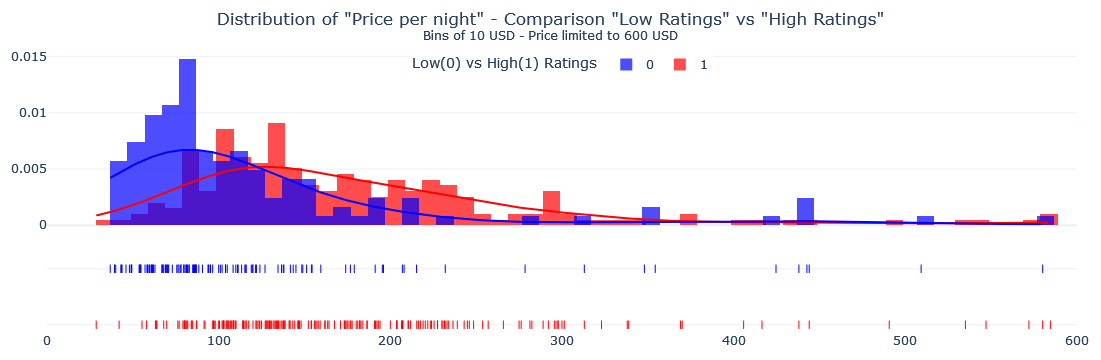

In [130]:
high_rating = ['1','0']
distrib = ff.create_distplot(
    [hotels.loc[hotels["high_rating"] == 1, "price_nite"], hotels.loc[hotels["high_rating"] == 0, "price_nite"]],
    high_rating,
    bin_size = 10,
    curve_type = 'kde',
    colors = colors)
distrib.update_layout(title_text = 'Distribution of "Price per night" - Comparison "Low Ratings" vs "High Ratings"<br><sup>Bins of 10 USD - Price limited to 600 USD</sup>')
distrib.update_layout(title_x = 0.5)
distrib.update_layout(xaxis = dict(range = [0,600]))
distrib.update_layout(legend_title_text='Low(0) vs High(1) Ratings')
distrib.update_layout(legend = dict(orientation = 'h', y=1, x=0.5, xanchor ='center'), margin = dict(b = 20, t = 50, l = 20, r = 20))
distrib.show()

### Comments:
- High-rating pricing distribution flatter.
- Low-rating more skewed with half the hotels below USD 90 per night.

__________________________________________________________________________________________________________________________________

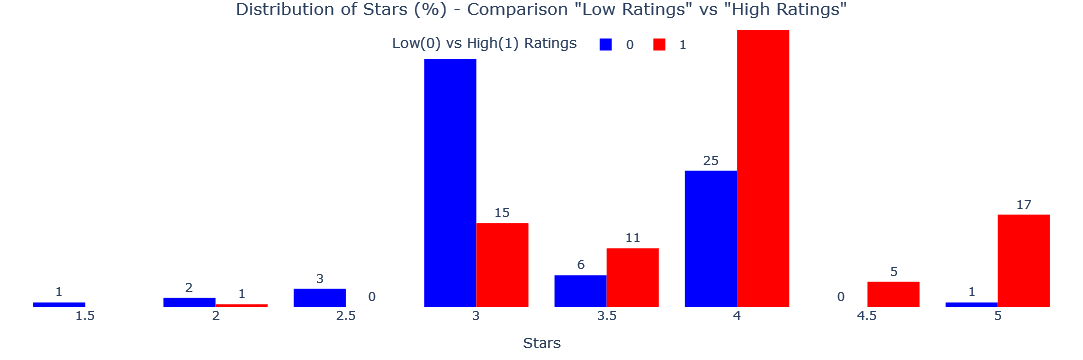

In [131]:
# Checking differences in Stars vs High_rating
graph = px.histogram(hotels, x = 'stars',
                     title = 'Distribution of Stars (%) - Comparison "Low Ratings" vs "High Ratings"',
                     labels = {0: 'Low Rating', 1: 'High Rating'},
                     histnorm = 'percent',
                     barmode = 'group',
                     color = 'high_rating',
                     color_discrete_map = {1: 'red', 0: 'blue'},
                     text_auto = True
                    )
graph.update_traces(texttemplate = '%{y:.0f}', textposition = 'outside')
graph.update_layout(title_x = 0.5)
graph.update_xaxes(title = 'Stars')
graph.update_yaxes(visible = False)
graph.update_layout(yaxis = dict(range = [0,50]))
graph.update_layout(legend_title_text='Low(0) vs High(1) Ratings')
graph.update_layout(legend = dict(orientation = 'h', y=1, x=0.5, xanchor ='center'), margin = dict(b = 20, t = 30, l = 20, r = 20))
graph.show()

In [132]:
# Creating a binary column with 4 stars as pivot
hotels['four_star_plus'] = hotels['stars'].apply(lambda x: 1 if x >= 4 else 0)

### Comments: 
- There is a clear split from 4 stars and above.
- Low-rating hotels are predominantly 3 stars whilst high-rating hotels peak as 4 stars.
- There is little variation on this variable (virtually no 1 or 2 stars) so regression on stars will be limited.
- As a consequence, we create a binary variable **4star+** to evaluate its impact on predictability
__________________________________________________________________________________________________________________________________

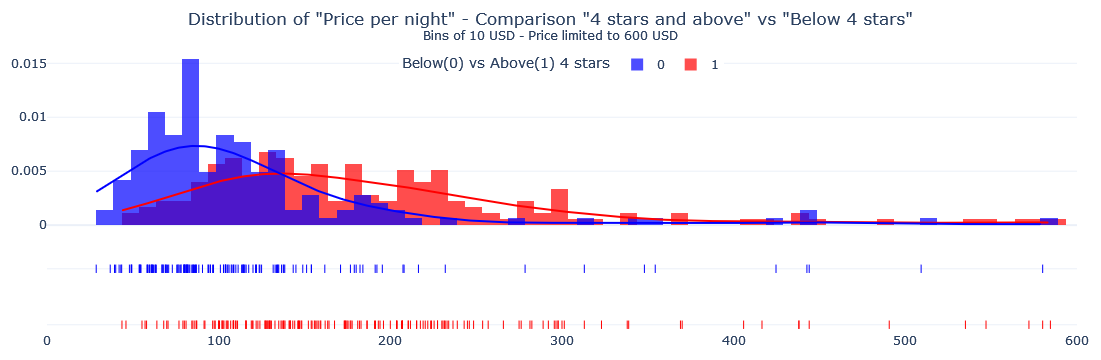

In [133]:
four_star_plus = ['1','0']
distrib = ff.create_distplot(
    [hotels.loc[hotels["four_star_plus"] == 1, "price_nite"], hotels.loc[hotels["four_star_plus"] == 0, "price_nite"]],
    four_star_plus,
    bin_size = 10,
    curve_type = 'kde',
    colors = colors)
distrib.update_layout(title_text = 'Distribution of "Price per night" - Comparison "4 stars and above" vs "Below 4 stars"<br><sup>Bins of 10 USD - Price limited to 600 USD</sup>')
distrib.update_layout(title_x = 0.5)
distrib.update_layout(xaxis = dict(range = [0,600]))
distrib.update_layout(legend_title_text='Below(0) vs Above(1) 4 stars')
distrib.update_layout(legend = dict(orientation = 'h', y=1, x=0.5, xanchor ='center'), margin = dict(b = 20, t = 50, l = 20, r = 20))
distrib.show()

### Comments: 
- We get a similar distribution to the price one.
- 4 stars+ spreading between 100 and 300 USD.
- Lower quality hotels more skewed (majority under USD 100).
__________________________________________________________________________________________________________________________________

### Distance Vs Rating

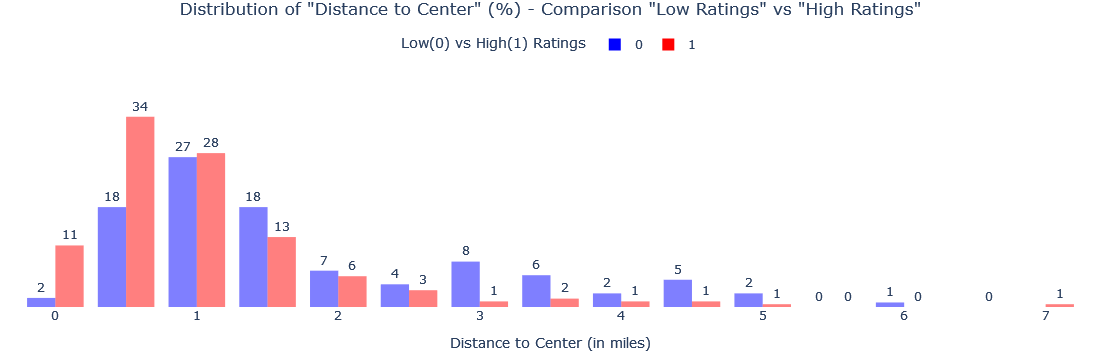

In [134]:
# Checking differences in Distance-to-the-Center vs High_rating
graph = px.histogram(hotels, x = 'distance',
                     title = 'Distribution of "Distance to Center" (%) - Comparison "Low Ratings" vs "High Ratings"',
                     histnorm = 'percent',
                     barmode = 'overlay',
                     nbins = 20,
                     color = 'high_rating',
                     color_discrete_map = {1: 'red', 0: 'blue'},
                     text_auto = True
                    )
graph.update_traces(texttemplate = '%{y:.0f}', textposition = 'outside')
graph.update_layout(title_x = 0.5, plot_bgcolor = 'white')
graph.update_xaxes(title = 'Distance to Center (in miles)')
graph.update_yaxes(visible = False)
graph.update_layout(barmode = 'group')
graph.update_layout(yaxis = dict(range = [0,50]))
graph.update_layout(legend_title_text='Low(0) vs High(1) Ratings')
graph.update_layout(legend = dict(orientation = 'h', y=1, x=0.5, xanchor ='center'), margin = dict(b = 20, t = 30, l = 20, r = 20))
graph.show()

### Comments:
Distribution of ratings differs according to distance:
- Almost 90% of "high-rating" hotels are under 2 miles from the city center of Prague.
- Over 1/3 of "low-rating" hotels are at 2 miles or above from the city center.
- The distribution of distance is not wide spread, most hotels being below 2 miles from the city center.

__________________________________________________________________________________________________________________________________

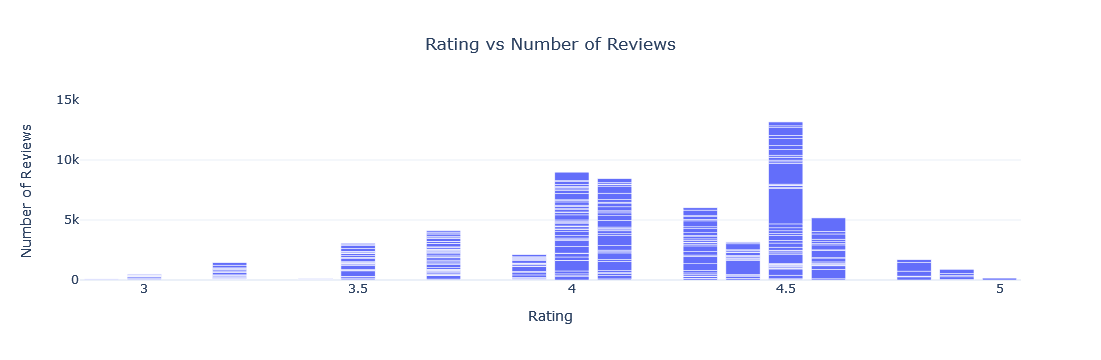

In [135]:
# Relationship between Rating and Number of Reviews
graph = px.bar(hotels, x = 'rating', y = 'rating_reviewcount',
                   title = 'Rating vs Number of Reviews'
                   )
graph.update_layout(title_x = 0.5, plot_bgcolor = 'white')
graph.update_layout(yaxis = dict(range = [0,15000]))
graph.update_xaxes(title = 'Rating')
graph.update_yaxes(title = 'Number of Reviews')
graph.show()

In [136]:
hotels['average_rating'] = hotels.apply(lambda row: row['rating'] * row['rating_reviewcount'], axis = 1)

# Sum the values in the 'Product' column
true_average_rating = hotels['average_rating'].sum()/hotels['rating_reviewcount'].sum()
print(f'The true average rating in Prague, weighed by the number of reviews, is {true_average_rating:.1f}')

The true average rating in Prague, weighed by the number of reviews, is 4.2


### Comments:
- the higher the rating, the more comments in absolute terms.
- please remember the average hotel rating in Prague is 4.0, still very few reviews below 4.0).
- calculating the true average rating (weighted by the number of reviews) we get an average review of 4.2.
- the variable is quite concentrated between a 3.9 and 4.6 rating (over 80% of all observations).
__________________________________________________________________________________________________________________________________

### Promotional impact:
We have no knowledge of promotional frequency nor weight in terms of transactions. The variable we select is Price Cuts.  

In [137]:
# Creating a binary variable on price cuts
hotels['price_cuts'] = hotels['offer_high'].apply(lambda x: 1 if x == "50%-75% offer" else 0)
offer_count = hotels['price_cuts'].sum()
print(offer_count)


48


#### Checking impact of deep cuts (50% to 75%) on price distribution

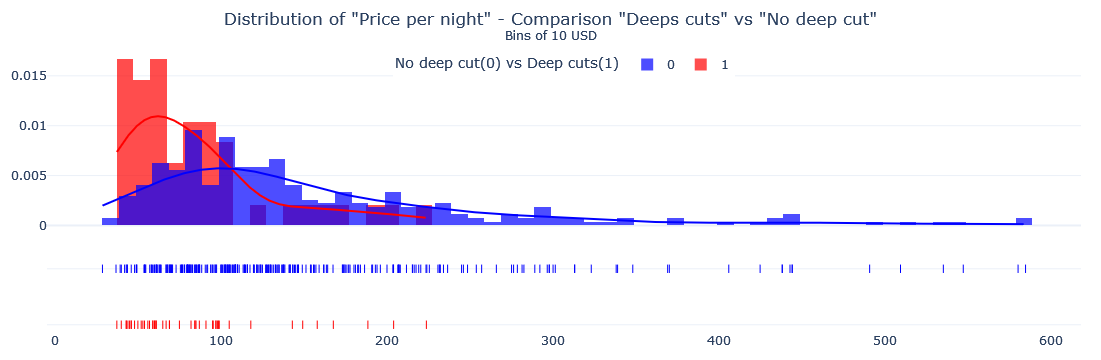

In [138]:
price_cuts = ['1','0']
distrib = ff.create_distplot(
    [hotels.loc[hotels["price_cuts"] == 1, "price_hi_off"], hotels.loc[hotels["price_cuts"] == 0, "price_nite"]],
    price_cuts,
    bin_size = 10,
    curve_type = 'kde',
    colors = colors)
distrib.update_layout(title_text = 'Distribution of "Price per night" - Comparison "Deeps cuts" vs "No deep cut"<br><sup>Bins of 10 USD</sup>')
distrib.update_layout(title_x = 0.5)
distrib.update_layout(legend_title_text='No deep cut(0) vs Deep cuts(1)')
distrib.update_layout(legend = dict(orientation = 'h', y=1, x=0.5, xanchor ='center'), margin = dict(b = 20, t = 50, l = 20, r = 20))
distrib.show()

### Comments:
Price cuts position hotels in the fighting zone below USD100. A similar analysis Vs "stars" shows that price cuts are in higher category hotels (marginally). Limited variation of this variable.

__________________________________________________________________________________________________________________________________

### PRICING

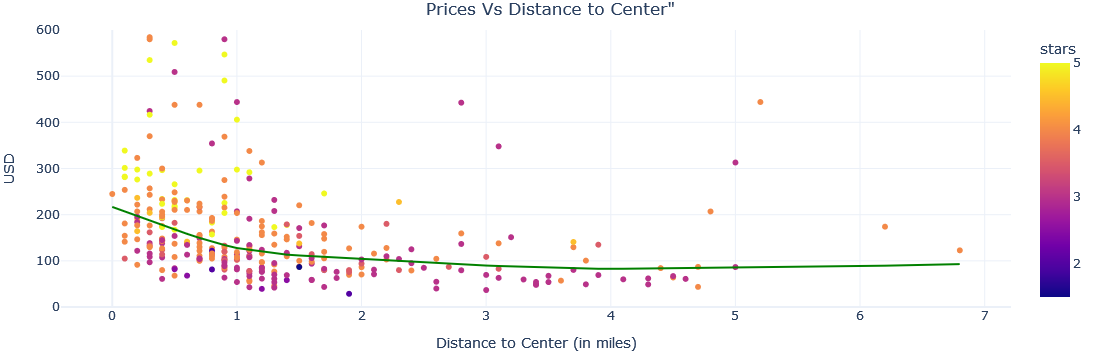

In [140]:
graph = px.scatter(hotels,
                   x = 'distance',
                   y = 'price_nite',
                   color = 'stars',
                   title = 'Prices Vs Distance to Center"',
                   trendline ='lowess',
                   trendline_color_override ='green'
                    )
graph.update_layout(title_x = 0.5, plot_bgcolor = 'white')
graph.update_xaxes(title = 'Distance to Center (in miles)')
graph.update_yaxes(title = 'USD')
graph.update_layout(yaxis = dict(range = [0,600]))
graph.update_layout(legend_title_text='Low(0) vs High(1) Ratings')
graph.update_layout(legend = dict(orientation = 'h', y=1, x=0.5, xanchor ='center'), margin = dict(b = 20, t = 30, l = 20, r = 20))
graph.show()

### Comments:
We use this "price" scatter plot to better understand the dynamics of the Prague marketplace:
- Almost 90% of "high-rating" hotels are under 2 miles from the city center of Prague.
- Over 1/3 of "low-rating" hotels are at 2 miles or above from the city center.
- There is a high concentration of hotels below 1 mile and many of them with sky-high prices in that short distance form the center.
_________________________________________________________________________________________________________________________________________

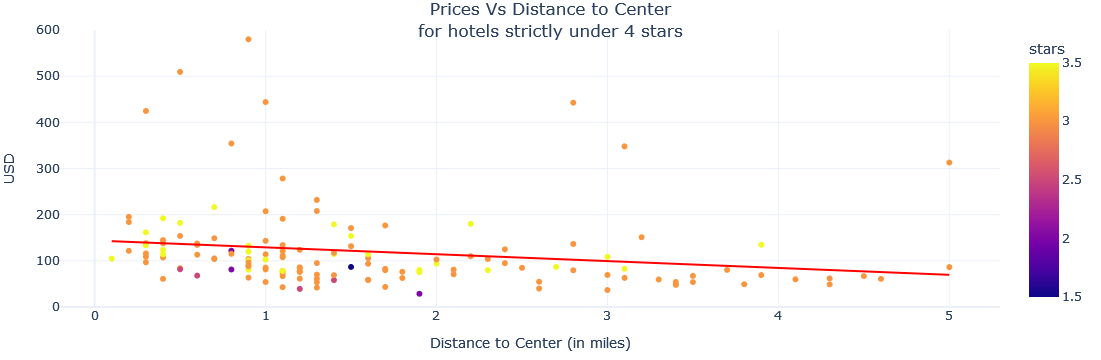

In [141]:
graph = px.scatter(hotels[hotels['stars'] < 4],
                   x = 'distance',
                   y = 'price_nite',
                   color = 'stars',
                   title = 'Prices Vs Distance to Center<br>for hotels strictly under 4 stars<br>',
                   trendline ='ols',
                   trendline_color_override ='red'
                    )
graph.update_layout(title_x = 0.5, plot_bgcolor = 'white')
graph.update_xaxes(title = 'Distance to Center (in miles)')
graph.update_yaxes(title = 'USD')
graph.update_layout(yaxis = dict(range = [0,600]))
graph.update_layout(legend_title_text='Low(0) vs High(1) Ratings')
graph.update_layout(legend = dict(orientation = 'h', y=1, x=0.5, xanchor ='center'), margin = dict(b = 20, t = 30, l = 20, r = 20))
graph.show()

### Comments:
Fine tuning the analysis on lower quality hotels (under 4 stars):
- Linear regression seems to fit this category.
- Although a number of 3 star outliers stay well outside this linear trend.
_________________________________________________________________________________________________________________________________________

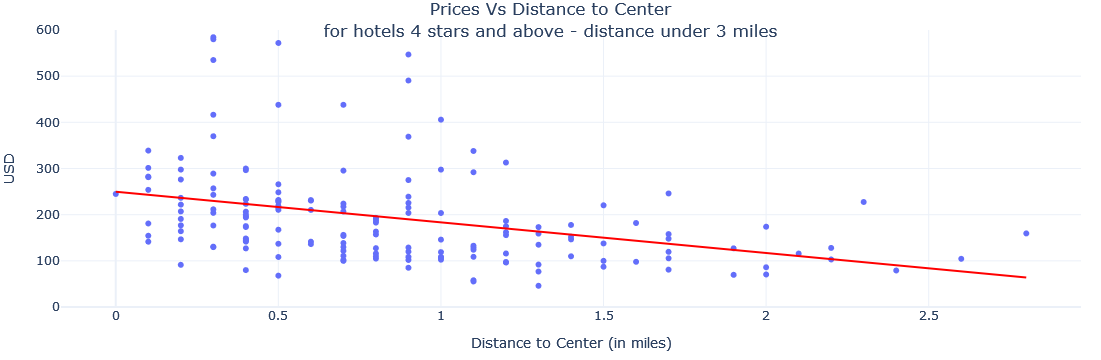

In [142]:
graph = px.scatter(hotels[(hotels['stars'] >= 4) & (hotels['distance'] < 3)],
                   x = 'distance',
                   y = 'price_nite',
                   title = 'Prices Vs Distance to Center<br>for hotels 4 stars and above - distance under 3 miles<br>',
                   trendline ='ols',
                   trendline_color_override ='red')
graph.update_layout(title_x = 0.5, plot_bgcolor = 'white')
graph.update_xaxes(title = 'Distance to Center (in miles)')
graph.update_yaxes(title = 'USD')
graph.update_layout(yaxis = dict(range = [0,600]))
graph.update_layout(legend_title_text='Low(0) vs High(1) Ratings')
graph.update_layout(legend = dict(orientation = 'h', y=1, x=0.5, xanchor ='center'), margin = dict(b = 20, t = 30, l = 20, r = 20))
graph.show()

### Comments:
Fine tuning the analysis on higher quality hotels (4 stars + within a 3 mile range from the city center):
- Some impact of distance.
- High variations though.
_____________________________________________________________________________________________________________________________________________

## 3 - REGRESSION ANALYSIS
Although not the focus of this work, we feel it is important to measure the main interactions of the variables.


In [143]:
# Linear regression of Price vs Distance on both "star" categories
reg1 = smf.ols(formula = "price_nite~distance", data = hotels[hotels['stars'] < 4]).fit(cov_type="HC1")
reg2 = smf.ols(formula = "price_nite~distance", data = hotels[(hotels['stars'] >= 4) & (hotels['distance'] < 3)]).fit(cov_type="HC1")
stargazer = Stargazer([reg1, reg2])
stargazer.covariate_order(["distance", "distance", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

### Comments:
As expected distance as a much higher negative impact on high quality hotels (4 star +).
_________________________________________________________________________________________________________________________________________

In [144]:
# Analysis of the impact of distance vs Price Variation (log)
reg1a = smf.ols(formula = "ln_price~distance", data = hotels[hotels['stars'] < 4]).fit(cov_type="HC1")
reg2a = smf.ols(formula = "ln_price~distance", data = hotels[(hotels['stars'] >= 4) & (hotels['distance'] < 3)]).fit(cov_type="HC1")
stargazer = Stargazer([reg1a, reg2a])
stargazer.covariate_order(["distance", "distance", "Intercept"])
stargazer.rename_covariates({"distance":"distance vs stars", "Intercept": "Constant"})
stargazer

### Comments:
Correlation is higher on price variation than on absolute price (1% significance level).
_________________________________________________________________________________________________________________________________________

In [145]:
# Checking impact of Deep Price Cuts (over 50%) on Ratings and Number of Reviews
reg3 = smf.ols(formula = "rating_reviewcount~price_cuts", data = hotels).fit(cov_type="HC1")
reg4 = smf.ols(formula = "rating~price_cuts", data = hotels[(hotels['stars'] >= 4) & (hotels['distance'] < 3)]).fit(cov_type="HC1")
stargazer = Stargazer([reg3, reg4])
stargazer.covariate_order(["price_cuts", "price_cuts", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

#### Comments: no interaction of deep price cuts on ratings nor on number of reviews.
_________________________________________________________________________________________________________________________________________

In [146]:
# Fine tuning impact of features on price variation
reg5 = smf.ols(formula = "ln_price~distance+stars+rating", data = hotels[hotels['stars'] < 4]).fit(cov_type="HC1")
reg6 = smf.ols(formula = "ln_price~distance+stars+rating", data = hotels[(hotels['stars'] >= 4) & (hotels['distance'] < 3)]).fit(cov_type="HC1")
reg7 = smf.ols(formula = "ln_price~distance+stars+rating", data = hotels).fit(cov_type="HC1")
reg8 = smf.ols(formula = "ln_price~distance+stars+rating", data = hotels[hotels['price_nite'] <= 300]).fit(cov_type="HC1")
stargazer = Stargazer([reg5, reg6, reg7, reg8])
stargazer.covariate_order(["distance", "stars", "rating", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

### Comments:
- We are getting optimal results with the regression of log(price) against distance, rating and stars (reg7):
variation in price as a function of distance from the center (-11 pts per mile), of stars (+31 pts for every additional star) and rating (+21 pts per every point of rating).
- We can get an even higher correlation **(70% _ reg8)** for all hotels at USD 300 per night or less, considering that the market above $300 is more niche with extra features for a specific customer target.

__________________________________________________________________________________________________________________________________

## 4 - PREDICTING THE PROBABILITY OF GETTING A HIGH RATING

##### As shown earlier, getting a high rating may command a higher price, hence the interest in understanding its mechanisms.
##### We also observed a possible impact of other features from their distribution against a low or high rating.
##### Is it possible to predict a high rating from the various features of a hotel? And which ones?
##### What is then the probability of getting a high rating depending on key features? 

## 4.1 - Linear Probability Modeling

#### OBJECTIVE:
Estimate linear probability model of being high rated (rating >= 4.0) against two explanatory variables: 
- number of stars,
- distance form the city center,
- other variables to investigate further.


#### LPM1 = modelling against categorical value of Stars

In [147]:
lpm1 = smf.ols("high_rating ~ stars", data = hotels).fit(cov_type="HC1")

#### LPM2 = modelling against absolute value of distance from the center

In [148]:
lpm2 = smf.ols("high_rating ~ distance", data = hotels).fit(cov_type="HC1")

In [149]:
stargazer = Stargazer([lpm1, lpm2])
stargazer.covariate_order(["stars", "distance", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

In [150]:
lpm1.conf_int(alpha = 0.01)

,0,1
Intercept,-1.1,-0.4
stars,0.3,0.4


#### COMMENTS:
LPM1 re. Stars
- Negative intercept (due to the low number of 1-star to 2-star hotels).
- Each star increases the probability to get a high rating by 37%.
- Very high F statistic.

Note: both parameters statistically significant at 1% - zero not in confidence interval.

In [151]:
lpm2.conf_int(alpha = 0.01)

,0,1
Intercept,0.7,0.9
distance,-0.2,-0.1


#### COMMENTS:
LPM2 re. Distance
- 79% of probability for hotels in Prague to get a high rating.
- Each mile from the center reduces the probability by 13%.

Note: both parameters statistically significant at 1% - zero not in interval

________________________________________________________________________________________________________________________________________

#### BINARY VARIABLES
Our initial analysis has idenitfied 2 milestones with regard to stars and distance: 4 stars and 1 mile.
As a consequence, we will use two binary variables on:
- stars: 4 stars and above   Vs   strictly below 4 stars,  
- distance: 1 mile and under    Vs    strictly above 1 mile.
The 4 star binary variable has been created, we add the distance binary variable to the dataset.

In [152]:
# Creating the "distance" binary variable from previous observations in data analysis
hotels['under_mile'] = hotels['distance'].apply(lambda x: 1 if x <= 1 else 0)

In [153]:
# Against the "4 star" binary variable
lpm3 = smf.ols("high_rating ~ four_star_plus", data = hotels).fit(cov_type="HC1")

In [154]:
# Against the "1 mile" binary variable
lpm4 = smf.ols("high_rating ~ under_mile", data = hotels).fit(cov_type="HC1")

In [155]:
stargazer = Stargazer([lpm3, lpm4])
stargazer.covariate_order(["four_star_plus", "under_mile", "Intercept"])
stargazer.rename_covariates({"four_star_plus":"4 star +", "under_mile":"1 mile and under", "Intercept": "Constant"})
stargazer

In [156]:
lpm3.conf_int()

,0,1
Intercept,0.3,0.4
four_star_plus,0.4,0.6


#### COMMENTS:
LPM3 re. 4 Stars Plus
- 36% of probability for hotels in Prague to get a high rating.
- Four stars and above increases the probability to get a high rating by 46%

Note: both parameters statistically significant at 1% - zero not in interval

In [157]:
lpm4.conf_int()

,0,1
Intercept,0.4,0.6
under_mile,0.2,0.4


#### COMMENTS:
LPM4 re. Distance
- 48% of probability for hotels in Prague to get a high rating.
- Being less than 1 away mile from the center increases the probability by 27%.
- F Statistic is low!

Note: both parameters statistically significant at 1% - zero not in interval
____________________________________________________________________________________________________________________________

#### Probability based on 2 variables: all variables showing statistically strong results at 1% significance, we try to model both ways (absolute and binary).

In [158]:
lpm5 = smf.ols("high_rating~stars + distance", data = hotels).fit(cov_type="HC1")
lpm6 = smf.ols("high_rating~four_star_plus + under_mile", data = hotels).fit(cov_type="HC1")
stargazer = Stargazer([lpm5, lpm6])
stargazer.covariate_order(["stars", "distance", "four_star_plus", "under_mile", "Intercept"])
stargazer.rename_covariates({"four_star_plus":"4 star +", "under_mile":"1 mile and under", "Intercept": "Constant"})
stargazer

In [159]:
lpm5.conf_int()

,0,1
Intercept,-0.8,-0.2
stars,0.3,0.4
distance,-0.1,-0.0


#### COMMENTS:
LPM5 re. Stars and Distance
- although statistically significant, the linear modelling gives a negative intercept.

We consequently drop this model.

In [160]:
lpm6.conf_int()

,0,1
Intercept,0.2,0.4
four_star_plus,0.3,0.5
under_mile,0.1,0.3


#### COMMENTS:
LPM6 re. "4 Stars+" and "1 mile"
- There is a 30% chance for any hotel to get a high rating.
- Being 4 star and above increases the probability by 42pts.
- Being 1 mile or under from the center increases the probability by 16 pts.
- Even if the F statistic is much lower than LPM1.

### WE WILL RETAIN LPM6 AS THE LPM MODEL IN FURTHER WORK

Note: both parameters statistically significant at 1% - zero not in interval

## 4.2 - Prediction

In [161]:
hotels["predict_lpm"] = lpm6.predict()
hotels["predict_lpm"].describe().round(4)
pd.set_option('display.max_rows', None)  # Display all rows
hotels["predict_lpm"]

13210   0.3
13211   0.7
13212   0.3
13213   0.7
13214   0.3
13216   0.3
13217   0.3
13219   0.3
13220   0.7
13222   0.7
13223   0.3
13224   0.5
13225   0.9
13226   0.7
13228   0.3
13229   0.3
13231   0.5
13233   0.3
13234   0.3
13236   0.9
13237   0.7
13238   0.3
13239   0.3
13240   0.7
13244   0.3
13245   0.7
13250   0.9
13252   0.7
13254   0.9
13255   0.9
13256   0.5
13258   0.9
13259   0.9
13260   0.9
13262   0.9
13265   0.9
13268   0.9
13271   0.3
13272   0.7
13276   0.3
13279   0.7
13281   0.9
13282   0.7
13284   0.3
13285   0.7
13287   0.3
13288   0.7
13289   0.7
13290   0.9
13291   0.3
13292   0.3
13296   0.5
13297   0.7
13299   0.9
13300   0.7
13301   0.9
13302   0.9
13304   0.5
13310   0.9
13311   0.5
13312   0.9
13313   0.9
13314   0.9
13315   0.9
13317   0.7
13320   0.7
13321   0.9
13322   0.9
13324   0.5
13325   0.9
13326   0.5
13327   0.5
13328   0.9
13330   0.9
13331   0.7
13332   0.5
13335   0.3
13337   0.5
13338   0.9
13339   0.9
13340   0.9
13342   0.9
13344   0.5
1334

In [162]:
pd.reset_option('display.max_rows')

#### Histogram of Prediction

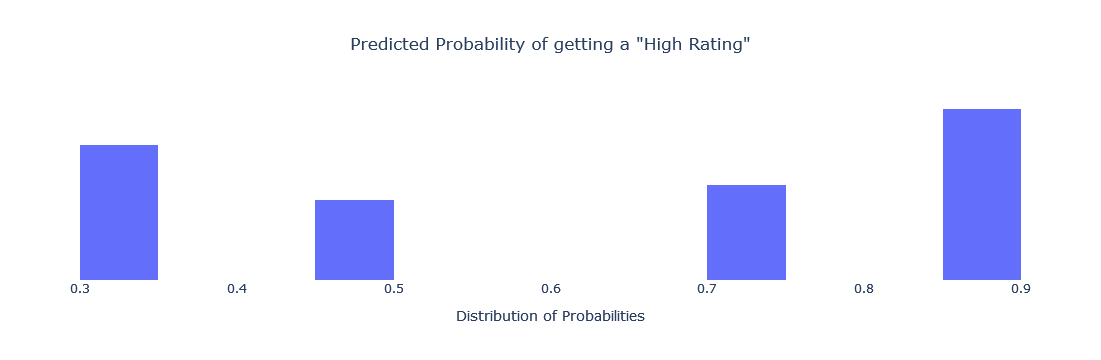

In [163]:
hist_prob = px.histogram(hotels, x = 'predict_lpm',
                     title = 'Predicted Probability of getting a "High Rating"',
                     histnorm = 'percent',
                     barmode = 'stack',
                     nbins = 20
                    )
hist_prob.update_layout(title_x = 0.5)
hist_prob.update_xaxes(title = 'Distribution of Probabilities')
hist_prob.update_yaxes(visible = False)
hist_prob.show()

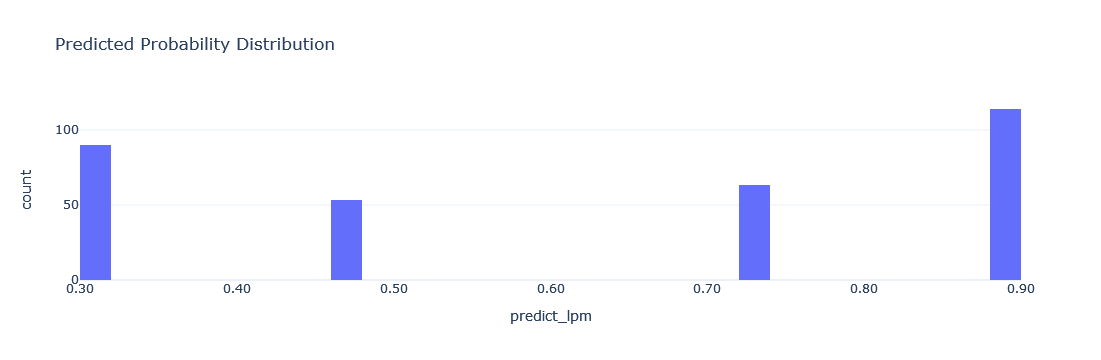

In [164]:
hist_prob = px.histogram(hotels, x='predict_lpm', nbins=30, title='Predicted Probability Distribution')

# Set the range of x-axis to include the full range of predicted probabilities
hist_prob.update_xaxes(tickformat=".2f")  # ".2f" specifies two digits after the decimal point

hist_prob.show()

#### COMMENTS
- Poorly distributed: the histogram has no resemblance with a normal distribution. This is partly due to the choice of binary variables that limit the distribution.
>  
>  
________________________________________________________________________________________________

## 4.3 - LOGIT & PROBIT

In [165]:
y, X = dmatrices("high_rating ~ four_star_plus + under_mile", hotels)
logit = sm.Logit(y, X)
logit_result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.534138
         Iterations 6


In [166]:
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            high_rating   No. Observations:                  320
Model:                          Logit   Df Residuals:                      317
Method:                           MLE   Df Model:                            2
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                  0.1964
Time:                        23:11:34   Log-Likelihood:                -170.92
converged:                       True   LL-Null:                       -212.70
Covariance Type:            nonrobust   LLR p-value:                 7.229e-19
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.8908      0.209     -4.254      0.000      -1.301      -0.480
four_star_plus     1.9530      0.269      7.263      0.000       1.426       2.480
under_mile         0.8392      0.268      3.134      0.002       0.314       1.364
==================================================================================
"""

In [167]:
hotels["pred_logit"] = logit_result.predict()
hotels["pred_logit"].describe()

count   320.0
mean      0.6
std       0.2
min       0.3
25%       0.3
50%       0.7
75%       0.9
max       0.9
Name: pred_logit, dtype: float64

In [168]:
logit_margef_results = logit_result.get_margeff()
logit_margef_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            high_rating
Method:                          dydx
At:                           overall
==================================================================================
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
four_star_plus     0.3462      0.031     11.266      0.000       0.286       0.406
under_mile         0.1488      0.045      3.297      0.001       0.060       0.237
==================================================================================
"""

#### Comments:
- The marginal results of the logit model are close to the LPM model: increase in probability of 35pts (Vs 42 for LPM) for "4 stars+"
and 15pts for "under 1 mile" (vs 16pts for the LPM model).
_____________________________________________________________________________________________________________________________________

#### The Probit model

In [169]:
y, X = dmatrices("high_rating ~ four_star_plus + under_mile", hotels)
probit = sm.Probit(y, X)
probit_result = probit.fit()
probit_result.summary()

Optimization terminated successfully.
         Current function value: 0.533975
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:            high_rating   No. Observations:                  320
Model:                         Probit   Df Residuals:                      317
Method:                           MLE   Df Model:                            2
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                  0.1966
Time:                        23:11:36   Log-Likelihood:                -170.87
converged:                       True   LL-Null:                       -212.70
Covariance Type:            nonrobust   LLR p-value:                 6.862e-19
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5426      0.125     -4.337      0.000      -0.788      -0.297
four_star_plus     1.1829      0.158      7.470      0.000       0.872       1.493
under_mile         0.4995      0.158      3.152      0.002       0.189       0.810
==================================================================================
"""

In [170]:
hotels["pred_probit"] = probit_result.predict()
hotels["pred_probit"].describe()

count   320.0
mean      0.6
std       0.2
min       0.3
25%       0.3
50%       0.7
75%       0.9
max       0.9
Name: pred_probit, dtype: float64

In [171]:
probit_margef_results = probit_result.get_margeff()
probit_margef_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:            high_rating
Method:                          dydx
At:                           overall
==================================================================================
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
four_star_plus     0.3561      0.034     10.525      0.000       0.290       0.422
under_mile         0.1504      0.046      3.289      0.001       0.061       0.240
==================================================================================
"""

#### Comments:
- The marginal results are very close to the logit numbers (within 1 pt range) on both variables.
- All variables between 0 and 1 just as Logit.
___________________________________________________________________________________________________

In [172]:
# Creating the summary dataframe:
prob_plot = pd.melt(
    hotels[["predict_lpm", "pred_logit", "pred_probit"]]
    .rename(columns = {"pred_logit": "Logit", "pred_probit": "Probit"}),
    value_vars = ["Logit", "Probit"],
    id_vars = ["predict_lpm"]
).drop_duplicates().sort_values(by = ["variable"])

In [173]:
prob_plot

,predict_lpm,variable,value
0,0.3,Logit,0.3
1,0.7,Logit,0.7
11,0.5,Logit,0.5
12,0.9,Logit,0.9
320,0.3,Probit,0.3
321,0.7,Probit,0.7
331,0.5,Probit,0.5
332,0.9,Probit,0.9


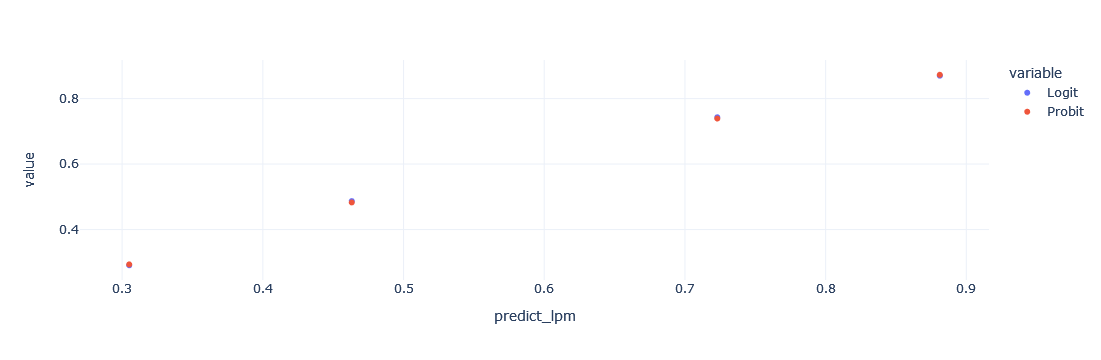

In [174]:
comp_plot = px.scatter(prob_plot, x = "predict_lpm", y = "value", color = "variable")
comp_plot

## 5 - CONCLUSIONS

To better understand the probability of getting a high rating (on average 60%), we come to the conclusion that:
- the probability to get a high rating is impacted by the hotel quality (4 star and above - +35pts)
- and the distance from Prague center (in our analysis "under 1 mile" is adding 15 pts to the probability.
The Probit and Logit give strong similar estimates.
Results satisfy the 1% significance level. However some indicators are less conclusive like the probability distribution particularly with the LPM. Besides the size of the final dataset (320), it is also the limited dispersion of the variables with stars concentrated at 3-4, distances massively below 2 miles (average is 1.2) and ratings fairly high (the weighted average of ratings is 4.2 on a scale of 5 but this is more on line with other major cities).
Both the Logit and Probit models gave better reassurance on the model than did the LPM.
#

### Appendix: European cities - comparison on Hotels 

In [175]:
hotel_cap = hotel_eur[(hotel_eur["accommodation_type"] == 'Hotel')].groupby('city', as_index = False).agg({'hotel_id':'count','stars': 'mean','distance': 'mean','rating':'mean','price_nite' : 'mean'}, inplace = True)
hotel_cap.rename(columns = {'hotel_id':'count'}, inplace = True)
hotel_cap = hotel_cap[hotel_cap['count'] >= 250]
hotel_cap

,city,count,stars,distance,rating,price_nite
0,Amsterdam,339,3.2,1.7,3.8,274.6
1,Athens,274,3.1,3.8,3.8,102.0
2,Barcelona,391,3.5,1.8,4.1,237.0
4,Berlin,423,3.5,2.8,4.0,129.7
16,Istanbul,1037,3.8,1.9,3.7,91.9
19,Lisbon,259,3.6,3.8,4.1,195.3
20,London,794,3.5,3.4,3.8,230.1
22,Madrid,339,3.6,4.1,4.1,190.4
24,Milan,512,3.4,5.4,3.8,223.9
26,Moscow,268,3.4,5.1,4.0,128.2


In [176]:
# STANDARD DEVIATION
hotel_cap = hotel_eur[(hotel_eur["accommodation_type"] == 'Hotel')].groupby('city', as_index = False).agg({'hotel_id':'count','stars': 'std','distance': 'std','rating':'std','price_nite' : 'std'}, inplace = True)
hotel_cap.rename(columns = {'hotel_id':'count'}, inplace = True)
hotel_cap = hotel_cap[hotel_cap['count'] >= 250]
hotel_cap

,city,count,stars,distance,rating,price_nite
0,Amsterdam,339,0.9,2.2,0.6,175.0
1,Athens,274,1.1,4.9,0.6,103.4
2,Barcelona,391,1.0,2.3,0.4,160.7
4,Berlin,423,0.7,2.2,0.5,54.4
16,Istanbul,1037,0.8,1.8,0.8,83.6
19,Lisbon,259,0.9,5.2,0.5,143.8
20,London,794,0.9,3.3,0.7,166.3
22,Madrid,339,0.8,4.6,0.4,152.1
24,Milan,512,0.9,6.6,0.5,225.8
26,Moscow,268,0.9,5.9,0.6,111.9
